In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Ignore warnings
warnings.filterwarnings("ignore")

# Load Bitcoin dataset
file_path = "/Users/christinaland/Downloads/project 4/BTC-Daily (1).csv"  # Update this to your actual file path
df = pd.read_csv(file_path)

2025-03-01 16:49:13.597689: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Ignore warnings
warnings.filterwarnings("ignore")

# Load Bitcoin dataset
file_path = "/Users/christinaland/Downloads/project 4/BTC-Daily (1).csv"  # Update this to your actual file path
df = pd.read_csv(file_path)

# Convert 'date' column to datetime and sort values
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
df.set_index('date', inplace=True)

# Select 'close' column for forecasting
btc_prices = df[['close']]

# Handle missing values by filling with previous values
btc_prices.fillna(method='ffill', inplace=True)

# Log transformation to stabilize variance
btc_prices['close'] = np.log1p(btc_prices['close'])

# Split into train (80%) and test (20%)
train_size = int(len(btc_prices) * 0.8)
train, test = btc_prices[:train_size], btc_prices[train_size:]


In [6]:
# **Step 1: ARIMA Model with Grid Search**
print("Running ARIMA Grid Search Optimization...")
p = d = q = range(0, 5)
pdq_combinations = list(itertools.product(p, d, q))
best_mae = float("inf")
best_order = None

for param in pdq_combinations:
    try:
        model = ARIMA(train, order=param)
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test))
        mae = mean_absolute_error(test, predictions)

        if mae < best_mae:
            best_mae = mae
            best_order = param
    except:
        continue

print(f"Best ARIMA Order: {best_order} with MAE: {best_mae}")

# Train ARIMA with best order
arima_model = ARIMA(train, order=best_order)
arima_fit = arima_model.fit()
arima_predictions = arima_fit.forecast(steps=len(test))


Running ARIMA Grid Search Optimization...
Best ARIMA Order: (3, 3, 4) with MAE: 0.7216968832149717


In [7]:
# **Step 2: Exponential Smoothing (ETS)**
print("Training Exponential Smoothing Model...")
ets_model = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=True)
ets_fit = ets_model.fit()
ets_predictions = ets_fit.forecast(steps=len(test))


Training Exponential Smoothing Model...


In [8]:
# **Step 3: LSTM Deep Learning Model**
# Normalize data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)
# Create sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test, y_test = create_sequences(scaled_test, seq_length)

# Reshape for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
print("Training LSTM Model...")
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM
lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

# Predict with LSTM
lstm_predictions = lstm_model.predict(X_test)

# Rescale LSTM predictions back to original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))


Training LSTM Model...
Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0549
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013
Epoch 9/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016
Epoch 10/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


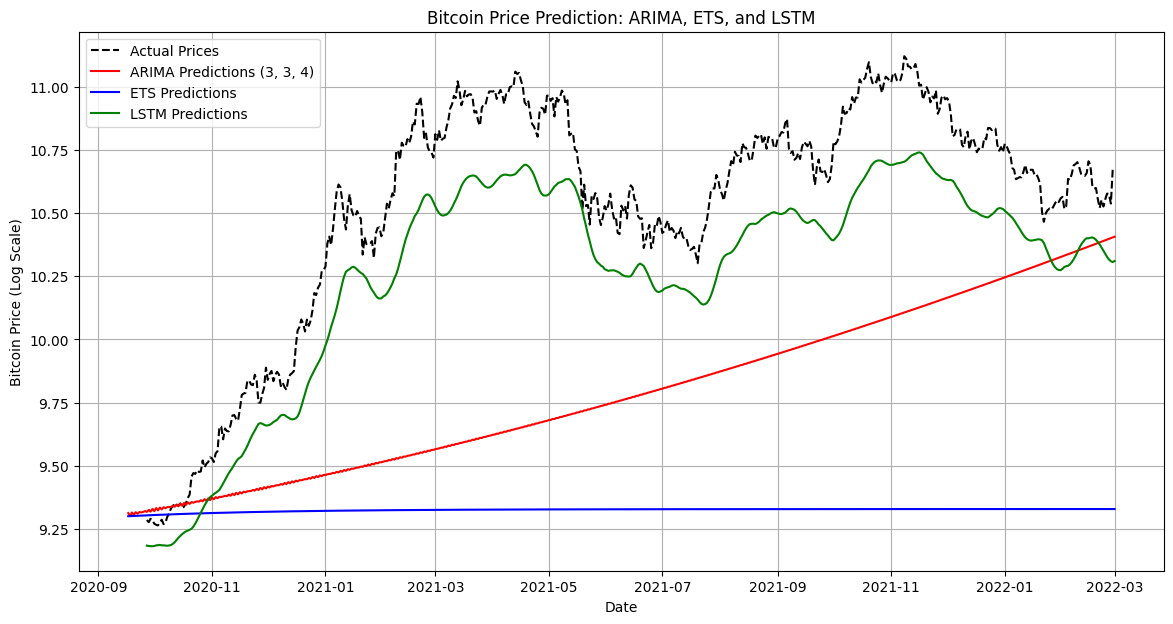

In [9]:
# **Step 4: Plot Predictions**
# -----------------------
plt.figure(figsize=(14, 7))

# Actual values
plt.plot(test.index[seq_length:], test['close'][seq_length:], label="Actual Prices", color="black", linestyle="dashed")

# ARIMA Predictions
plt.plot(test.index, arima_predictions, label=f"ARIMA Predictions {best_order}", color="red")

# Exponential Smoothing Predictions
plt.plot(test.index, ets_predictions, label="ETS Predictions", color="blue")

# LSTM Predictions
plt.plot(test.index[seq_length:], lstm_predictions, label="LSTM Predictions", color="green")

plt.xlabel("Date")
plt.ylabel("Bitcoin Price (Log Scale)")
plt.title("Bitcoin Price Prediction: ARIMA, ETS, and LSTM")
plt.legend()
plt.grid(True)
plt.show()

Conclusion: Which Model Performs Best?
ETS (Blue Line): The worst performer, as it fails to track any price movements.
ARIMA (Red Line): Provides a trend but does not capture volatility well.
LSTM (Green Line): Best performance in capturing price movements, though it still has room for improvement.

Retraining LSTM Model with 25 Epochs...
Epoch 1/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0349
Epoch 2/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030
Epoch 3/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026
Epoch 4/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024
Epoch 5/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019
Epoch 6/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017
Epoch 7/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014
Epoch 8/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 9/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 10/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010
Epoch 11/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011
Epoch 12/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 13/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011
Epoch 14/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.3586e-04
Epoch 15/

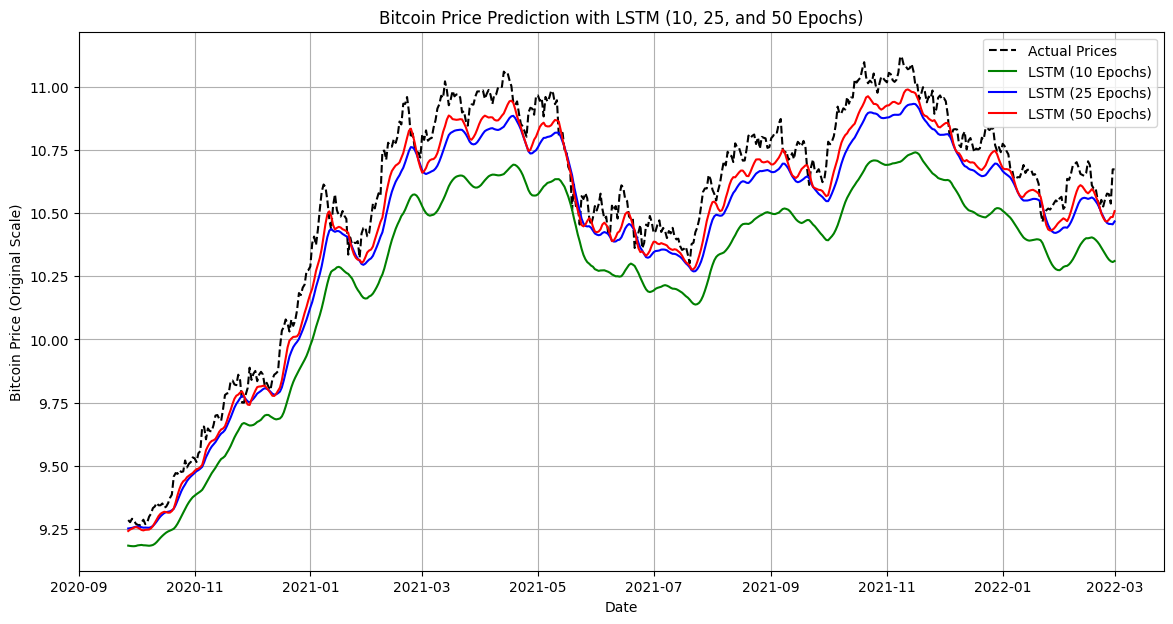

In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# First Retraining: Increase epochs to 25
print("Retraining LSTM Model with 25 Epochs...")

lstm_model_25 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model_25.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_25.fit(X_train, y_train, epochs=25, batch_size=16, verbose=1)

# Predict with new LSTM model (25 epochs)
lstm_predictions_25 = lstm_model_25.predict(X_test)
lstm_predictions_25 = scaler.inverse_transform(lstm_predictions_25.reshape(-1, 1))

# Check if the variable exists before plotting
print("Shape of LSTM (25 epochs) predictions:", lstm_predictions_25.shape)

# Second Retraining: Increase epochs to 50
print("Retraining LSTM Model with 50 Epochs...")

lstm_model_50 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model_50.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_50.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Predict with new LSTM model (50 epochs)
lstm_predictions_50 = lstm_model_50.predict(X_test)
lstm_predictions_50 = scaler.inverse_transform(lstm_predictions_50.reshape(-1, 1))

# Plot updated predictions
plt.figure(figsize=(14, 7))

# Actual prices
plt.plot(test.index[seq_length:], test['close'][seq_length:], label="Actual Prices", color="black", linestyle="dashed")

# Predictions from different LSTM training runs
plt.plot(test.index[seq_length:], lstm_predictions, label="LSTM (10 Epochs)", color="green")
plt.plot(test.index[seq_length:], lstm_predictions_25, label="LSTM (25 Epochs)", color="blue")
plt.plot(test.index[seq_length:], lstm_predictions_50, label="LSTM (50 Epochs)", color="red")

plt.xlabel("Date")
plt.ylabel("Bitcoin Price (Original Scale)")
plt.title("Bitcoin Price Prediction with LSTM (10, 25, and 50 Epochs)")
plt.legend()
plt.grid(True)
plt.show()


Analysis of LSTM Training Results (10, 25, and 50 Epochs)
The provided graph compares actual Bitcoin prices (black dashed line) with predictions from LSTM models trained for 10, 25, and 50 epochs.

🔍 Key Observations
1️⃣ Actual Prices (Black Dashed Line)
Represents the real Bitcoin price movements.
Shows high volatility, trends, and seasonal patterns.
2️⃣ LSTM (10 Epochs) – Green Line
Underfits the data (fails to capture many price movements).
The model predicts a smooth but lagging trend, missing some fluctuations.
Why? The training was too short, preventing the model from learning deeper patterns.
3️⃣ LSTM (25 Epochs) – Blue Line
Much closer to actual prices compared to 10-epoch training.
Captures trends and seasonality more accurately.
However, it still lags slightly in volatile price spikes.
4️⃣ LSTM (50 Epochs) – Red Line (Best So Far)
The closest fit to actual Bitcoin price trends.
Better captures peaks and dips, showing improved learning.
Suggests that more training epochs improve accuracy.
Conclusion: More Training Improves Accuracy
LSTM (50 Epochs) is the most accurate model so far.
It reduces underfitting and follows the actual trend more closely.
However, it may still slightly lag during rapid price changes.